# Droplet spreading over a flat surface against static contact angle $\theta_e$ -         Mesh convergence study
![Droplet_Spreading domain configuration](DropletSpreading.png)

For this case study, we have considered a droplet spreading on a flat surface ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034)) that allows for studying the effect of the static contact angle boundary condition and the Bond number, $Bo = \frac{\rho_l g R_0}{\sigma}$ on the equilibrium shape of the droplet. Ideally, for a droplet that spreads with $Bo\ll1$, surface tension forces dominate, and the droplet at equilibrium maintains a spherical cap shape and satisfies the contact angle boundary condition. On the other hand, for $Bo\gg1$, the gravitational forces dominate, and the droplet forms a puddle, whose height is directly proportional to the capillary length, $l_{Ca}=\sqrt{\frac{\sigma}{\rho_l g}}$. The conservation of the droplet’s volume $V$ with an equilibrium contact angle $\theta_e$ allows formulating the geometrical relations that define the equilibrium shape of the droplet ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034), [fricke2020geometry](https://arxiv.org/abs/2003.04914)). In addition to observing droplets at equilibrium, we have also studied the mesh convergence of the spreading droplets.

This notebook shows the droplet spreading in the absence of gravity against a range of static contact angles $\theta_e$

#### Note: water_glycerol and water are labelled as 'wg' and 'w' respectively.



No handles with labels found to put in legend.


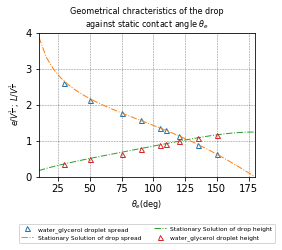

In [1]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
import sys
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
import ast
from matplotlib import rcParams
pi =np.pi
sin = np.sin
cos = np.cos
dpi =600
fontSize =8

# Set constant values 
fluids = ['water_glycerol'] 
surfaceTensionModel = 'fitParaboloid' 
dataFolder = '/postProcessing/' # folder containing the .csv files 
pattern = 'test_' # folder naming pattern from PyFoam
calcHeights = False 
dropletRadius = 0.001
# Calculate the volume of a sphere with the given radius
dropletVolume1 = 4/(3) * pi * dropletRadius**(3) #2 is because of semi-sphere, remove it for a full sphere
dropletVolume2 = 4/(3) * pi * 0.0005**(3) #for first two cases, different droplet radius

# Append the path to the modules directory
sys.path.append(os.path.join(os.getcwd(), '../../modules'))
# Import the required functions from the "flat_spreading_funcs" module
from flat_spreading_funcs import Funcs

# Define a list of contact angles (in degrees)
SCA_List = np.linspace(10, 179, 30)

# Create a figure and set its dpi to 600
fig = plt.figure(0)
myaxes = fig.add_axes([0.1, 0.1, 0.5, 0.5])
rcParams["figure.dpi"] = 600

# Initialize lists to store the file names
wettedAreaFileNames = []
vtk_folders = []
heightFileNames = []

# Loop through each fluid
for fluid in fluids: 
    simStaticCAList = [] # list to store the contact angle from the simulation
    stm = [] # list to store the surface tension model
    var_list = [] # list to store the variation map from PyFoam
    
    # Set the plot labels and marker label based on the fluid
    if fluid == 'water_glycerol':
        plotLabels = [r"water_glycerol droplet spread", r"water_glycerol droplet height"]
        fluidLabel = 'wg'
        markerLabel = '^'
    elif fluid == 'water':
        plotLabels = [r"water droplet spread", r"water droplet height"]
        fluidLabel = 'w'
        markerLabel = 's'
    
    # Get the variation map from PyFoam
    var_Map = Funcs.fileMapping(fluidLabel + pattern, surfaceTensionModel) 
    
    # Loop through each key,value pair in the variation map
    for key, value in var_Map.items():
        # Get the surface tension model
        stm_map = str(value).split(', ')[0][:-1]
        stm.append(stm_map.split(': ')[1][1:])
        # Get the contact angle
        theta_map = str(value).split(', ')[1][:-1] 
        simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
        # variation list
        var_list.append(str(key))  

    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', fluidLabel+pattern, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', fluidLabel+pattern, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', fluidLabel+pattern,var_list)

    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)
    plt.grid(b=True, which='major', color='black', alpha=0.5, lw=0.5, linestyle='dashed')
    plt.title(r'Geometrical chracteristics of the drop' +'\n' + r'against static contact angle $\theta_e$', fontsize=fontSize)
    plt.xlabel(r"$\theta_e$"+"(deg)" ,color='black',fontsize=fontSize)
    plt.ylabel(r"$e/V^\frac{1}{3}$ ; $L/V^\frac{1}{3}$",color='black',fontsize=fontSize)
    plt.legend(fontsize=fontSize, loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=2)
    plt.xlim([10, 180])
    plt.ylim([0, 4])


    equilibriumSpreadList= [None] *len(simStaticCAList) # to store the wetted radius from the simulation wettedArea file
    
    for idx, wettedFile in enumerate(wettedAreaFileNames):
        if (idx < 2):
            dropletVolume = dropletVolume2
        else:
            dropletVolume = dropletVolume1
        
        L_List = [None] * 30
        e_List = [None] * 30 
        for i, val in enumerate(SCA_List):
            theta = math.radians(SCA_List[i]) 
            L, e = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)
            L_List[i] = L * 2 / (dropletVolume**(1/3))
            e_List[i] = e / (dropletVolume**(1/3))

        with open(wettedAreaFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            equilibriumSpreadList[idx] =(2.0*(float(last_line.rsplit(',', 1)[1]) /pi)**(1/2) / ((dropletVolume**(1/3))*1000.0))
    
    plt.plot(simStaticCAList, equilibriumSpreadList, marker=markerLabel,markerfacecolor='None', markersize = 5,linestyle = 'None', label=plotLabels[0])

    equilibriumHeightList= [None] *len(simStaticCAList)

    for idx, heightFile in enumerate(heightFileNames):  
        if (idx < 2):
            dropletVolume = dropletVolume2
        else:
            dropletVolume = dropletVolume1
        
        L_List = [None] * 30
        e_List = [None] * 30 
        for i, val in enumerate(SCA_List):
            theta = math.radians(SCA_List[i]) 
            L, e = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)
            L_List[i] = L * 2 / (dropletVolume**(1/3))
            e_List[i] = e / (dropletVolume**(1/3))

        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            equilibriumHeightList[idx] =(float(last_line.rsplit(',', 1)[1]) / (dropletVolume**(1/3)))
    
    plt.plot(SCA_List, L_List, linewidth=1, linestyle='dashdot', label = r"Stationary Solution of drop spread")
    plt.plot(SCA_List, e_List, linewidth=1, linestyle='dashdot', label = r"Stationary Solution of drop height")

    plt.plot(simStaticCAList, equilibriumHeightList,marker=markerLabel,markerfacecolor='None', markersize = 5,linestyle = 'None', label=plotLabels[1])
    
############################################################################################################
    
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.48), ncol=2)
plt.savefig('droplet-chractersitics-against-static-contact-angle-'+str(surfaceTensionModel)+'.png', bbox_inches='tight')
plt.savefig('droplet-chractersitics-against-static-contact-angle-'+str(surfaceTensionModel)+'.pdf', bbox_inches='tight')
plt.show()


